<a href="https://colab.research.google.com/github/Gabriel-Barroso-Ventura/recommendation-system-computer-vision/blob/main/Recommendation-system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recommendation System Based on Computer Vision**


In this project, a recommendation system was created that aims to recommend products based on similarity with another product passed as input to the system. Python was used for the code and machine learning techniques


In [1]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# downloading raw images from kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/images/58150.jpg  
  inflating: myntradata

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
Processadas 10000 imagens de 11000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━

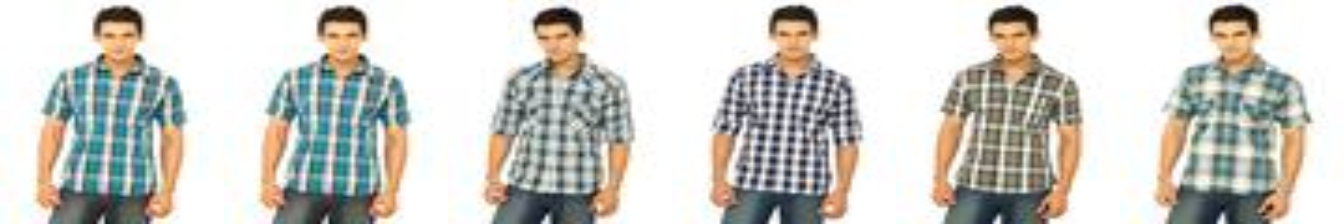

In [11]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
import cv2
import os
from google.colab.patches import cv2_imshow

class RecomendadorProdutos:
    def __init__(self, diretorio_banco_dados):
        # Carrega o modelo VGG16 pré-treinado (sem as camadas totalmente conectadas)
        self.modelo = VGG16(weights='imagenet', include_top=False, pooling='avg')
        self.diretorio_banco_dados = diretorio_banco_dados
        self.caracteristicas_banco = {}
        self.extrair_caracteristicas_banco()

    def preprocessar_imagem(self, caminho_imagem):
        # Carrega e pré-processa a imagem
        img = image.load_img(caminho_imagem, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array

    def extrair_caracteristicas(self, imagem_preprocessada):
        # Extrai características usando o modelo VGG16
        caracteristicas = self.modelo.predict(imagem_preprocessada)
        return caracteristicas.flatten()

    def extrair_caracteristicas_banco(self):
        # Extrai características das imagens de 1.jpg até 1000.jpg
        limite_imagens = 11000

        # Processa as imagens de 1 até 1000
        for numero in range(10000, limite_imagens + 1):
            nome_imagem = f"{numero}.jpg"
            caminho = os.path.join(self.diretorio_banco_dados, nome_imagem)

            # Verifica se a imagem existe
            if os.path.exists(caminho):
                img_preprocessada = self.preprocessar_imagem(caminho)
                self.caracteristicas_banco[nome_imagem] = self.extrair_caracteristicas(img_preprocessada)

                # Opcional: mostrar progresso
                if numero % 100 == 0:
                    print(f"Processadas {numero} imagens de {limite_imagens}")
            else:
                print(f"Aviso: Imagem {nome_imagem} não encontrada")

    def encontrar_produtos_similares(self, imagem_consulta, num_recomendacoes=5):
        # Pré-processa a imagem de consulta
        img_preprocessada = self.preprocessar_imagem(imagem_consulta)
        caracteristicas_consulta = self.extrair_caracteristicas(img_preprocessada)

        # Calcula a similaridade com todas as imagens do banco
        similaridades = {}
        for imagem, caracteristicas in self.caracteristicas_banco.items():
            similaridade = cosine_similarity(
                caracteristicas_consulta.reshape(1, -1),
                caracteristicas.reshape(1, -1)
            )[0][0]
            similaridades[imagem] = similaridade

        # Retorna as top N imagens mais similares
        produtos_similares = sorted(similaridades.items(),
                                  key=lambda x: x[1],
                                  reverse=True)[:num_recomendacoes]

        return produtos_similares

    def mostrar_imagens(self, imagem_consulta, produtos_similares):
        # Carrega e redimensiona a imagem de consulta
        img_consulta = cv2.imread(imagem_consulta)
        img_consulta = cv2.resize(img_consulta, (224, 224))

        # Cria uma lista com todas as imagens (consulta + similares)
        todas_imagens = [img_consulta]
        titulos = ['Imagem Consulta']

        # Carrega e adiciona as imagens similares
        for produto, similaridade in produtos_similares:
            caminho = os.path.join(self.diretorio_banco_dados, produto)
            img = cv2.imread(caminho)
            img = cv2.resize(img, (224, 224))
            todas_imagens.append(img)
            titulos.append(f'Similaridade: {similaridade:.2f}')

        # Cria uma única imagem com todas as imagens lado a lado
        imagem_final = np.hstack(todas_imagens)

        # Mostra a imagem
        cv2_imshow(imagem_final)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

# Exemplo de uso
if __name__ == "__main__":
    # Inicializa o recomendador com o diretório do banco de dados
    recomendador = RecomendadorProdutos("/content/myntradataset/images")

    # Encontra produtos similares para uma imagem de consulta
    imagem_consulta = "/content/myntradataset/images/10800.jpg"
    produtos_similares = recomendador.encontrar_produtos_similares(imagem_consulta)

    # Exibe os resultados
    print("Produtos similares encontrados:")
    for produto, similaridade in produtos_similares:
        print(f"Produto: {produto}, Similaridade: {similaridade:.2f}")

    # Mostra as imagens na tela
    recomendador.mostrar_imagens(imagem_consulta, produtos_similares)
